In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes, convolve
from tqdm import tqdm
from joblib import Parallel, delayed
import gc
import os

# Set plotting resolution
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120

In [19]:
def initialize_triangle_segments():
    """
    Initialize a mathematically correct equilateral triangle 
    with side length = 1 and centroid at a reasonable location.
    
    Returns:
        segments: list of 2x2 numpy arrays, each representing a line segment.
    """
    # Triangle with side length 1
    A = np.array([0.0, 0.0])
    B = np.array([1.0, 0.0])
    C = np.array([0.5, np.sqrt(3)/2])

    # No scaling, no shifting
    points = np.array([A, B, C])

    segments = [
        np.array([points[0], points[1]]),
        np.array([points[1], points[2]]),
        np.array([points[2], points[0]])
    ]

    return segments


def koch_iteration_step(segments):
    """
    Perform one Koch refinement step on a list of segments.
    """
    new_segments = []
    for seg in segments:
        A, B = seg
        d = B - A
        P1 = A + (1/3) * d
        P2 = A + (2/3) * d
        mid = (P1 + P2) / 2
        d_norm = d / np.linalg.norm(d)
        bump_direction = np.array([d_norm[1], -d_norm[0]])
        bump_height = (np.linalg.norm(d) / 3) * np.sqrt(3) / 2
        bump = mid + bump_direction * bump_height

        new_segments.append(np.array([A, P1]))
        new_segments.append(np.array([P1, bump]))
        new_segments.append(np.array([bump, P2]))
        new_segments.append(np.array([P2, B]))
    return new_segments

def rasterize_segments_to_image(segments, image_size=512, padding_pixels=2):
    """
    Rasterize a set of 2D segments into a binary image using bounding-box logic only.
    
    Args:
        segments: list of 2x2 arrays (in real coordinates)
        image_size: size of the longer axis in pixels (int)
        padding_pixels: how many pixels of black border to pad on all sides
    
    Returns:
        binary mask (np.ndarray) with shape (H, W)
    """
    all_points = np.vstack(segments)
    x_min, y_min = np.min(all_points, axis=0)
    x_max, y_max = np.max(all_points, axis=0)

    width = x_max - x_min
    height = y_max - y_min

    # Determine aspect ratio and pixel dimensions
    aspect_ratio = height / width if width != 0 else 1.0

    if aspect_ratio >= 1.0:
        H = image_size
        W = int(np.round(image_size / aspect_ratio))
    else:
        W = image_size
        H = int(np.round(image_size * aspect_ratio))

    H += 2 * padding_pixels
    W += 2 * padding_pixels

    mask = np.zeros((H, W), dtype=bool)

    for seg in segments:
        A, B = seg

        # Normalize into [0, 1] relative to bounding box
        A_norm = (A - [x_min, y_min]) / [width, height]
        B_norm = (B - [x_min, y_min]) / [width, height]

        draw_W = W - 2 * padding_pixels
        draw_H = H - 2 * padding_pixels
        A_px = (A_norm * [draw_W - 1, draw_H - 1]).astype(int)
        A_px += padding_pixels
        B_px = (B_norm * [draw_W - 1, draw_H - 1]).astype(int)
        B_px += padding_pixels

        # Interpolate points
        num_points = max(abs(B_px - A_px)) + 1
        x_vals = np.linspace(A_px[0], B_px[0], num_points).astype(int)
        y_vals = np.linspace(A_px[1], B_px[1], num_points).astype(int)

        x_vals = np.clip(x_vals, 0, W - 1)
        y_vals = np.clip(y_vals, 0, H - 1)

        mask[y_vals, x_vals] = True

    return binary_fill_holes(mask)



def compute_perimeter_4_connected(mask):
    """
    Compute perimeter of a binary mask using 4-connected convolution method.
    """
    kernel = np.array([[0,1,0], [1,0,1], [0,1,0]])
    neighbor_count = convolve(mask.astype(int), kernel, mode='constant', cval=0)
    perimeter_pixels = (mask) & (neighbor_count < 4)
    return np.sum(perimeter_pixels)

def measure_area_perimeter(mask):
    """
    Given a binary mask, compute area and perimeter (4-connected perimeter).
    """
    area = np.sum(mask)
    peri = compute_perimeter_4_connected(mask)
    return area, peri

def slice_and_mirror_segments(segments, fraction=2/3):
    """
    Slice the snowflake at a fraction of its own width,
    mirror across that vertical slice, and return combined segments.

    No rescaling. Keeps coordinates in their original scale.
    """
    all_points = np.vstack(segments)
    x_min = np.min(all_points[:,0])
    x_max = np.max(all_points[:,0])
    x_cut = x_min + fraction * (x_max - x_min)

    sliced = []
    for seg in segments:
        A, B = seg
        if A[0] <= x_cut and B[0] <= x_cut:
            sliced.append(seg)

    mirrored = []
    for seg in sliced:
        A, B = seg.copy(), seg.copy()
        A[0][0] = 2 * x_cut - A[0][0]
        B[1][0] = 2 * x_cut - B[1][0]
        mirrored.append(np.array([A[0], B[1]]))

    return sliced + mirrored


In [20]:
def single_raster_measure(size, segments):
    """
    Rasterize at one size and measure area and perimeter.
    """
    mask = rasterize_segments_to_image(segments, size)
    area, peri = measure_area_perimeter(mask)
    del mask
    gc.collect()
    return area, peri, size

def multi_raster_area_perimeter_parallel_safe(segments, min_size=256, max_size=4096, num_sizes=50,
                                               plot_some=False, save_every=10, save_prefix="raster_data",
                                               batch_size=10, n_jobs=-1):
    """
    Parallel, RAM-clearing, crash-resilient rasterization and measurement.
    """
    sizes = np.linspace(min_size, max_size, num_sizes, dtype=int)
    areas = []
    perimeters = []
    done_sizes = []

    os.makedirs("intermediate_saves", exist_ok=True)
    plot_indices = set(np.linspace(0, len(sizes) - 1, 5, dtype=int)) if plot_some else set()

    with tqdm(total=len(sizes), desc="Rasterizing and Measuring") as pbar:
        for batch_start in range(0, len(sizes), batch_size):
            batch_sizes = sizes[batch_start : batch_start + batch_size]

            results = Parallel(n_jobs=n_jobs)(
                delayed(single_raster_measure)(size, segments) for size in batch_sizes
            )

            for area, peri, sz in results:
                areas.append(area)
                perimeters.append(peri)
                done_sizes.append(sz)

                if plot_some and sz in sizes[list(plot_indices)]:
                    mask = rasterize_segments_to_image(segments, sz)
                    plt.figure(figsize=(4, 4))
                    plt.imshow(mask, cmap='gray')
                    plt.title(f"Raster Size: {sz}")
                    plt.axis('off')
                    plt.show()
                    del mask
                    gc.collect()

                pbar.update(1)

            # Save intermediate after each batch
            save_path = f"intermediate_saves/{save_prefix}_up_to_{batch_start+len(batch_sizes)}.npz"
            np.savez(save_path,
                     areas=np.array(areas),
                     perimeters=np.array(perimeters),
                     sizes=np.array(done_sizes))
            tqdm.write(f"Saved intermediate data at {save_path}")
            gc.collect()

    return np.array(areas), np.array(perimeters), np.array(done_sizes)



In [21]:
def plot_loglog_perimeter_vs_area(areas, perimeters):
    """
    Plot log(Perimeter) vs log(Area) and estimate fractal dimension.
    """
    logA = np.log(areas)
    logP = np.log(perimeters)

    valid = np.isfinite(logA) & np.isfinite(logP)
    logA = logA[valid]
    logP = logP[valid]

    if len(logA) < 2:
        raise ValueError("Not enough valid points to fit.")

    slope, intercept = np.polyfit(logA, logP, 1)
    D_estimate = 2 * slope

    plt.figure(figsize=(6,6))
    plt.plot(logA, logP, 'o-', label=f'Slope={slope:.4f}, D~{D_estimate:.4f}')
    plt.xlabel('log(Area)')
    plt.ylabel('log(Perimeter)')
    plt.title('Perimeter vs Area Scaling')
    plt.legend()
    plt.grid(True)
    plt.show()

    return D_estimate


In [22]:
from skimage.draw import line
from scipy.ndimage import binary_fill_holes

def rasterize_segments_to_image_2(segments, image_size=512, padding_pixels=2, min_width=0.01, min_height=0.01):
    """
    Rasterize 2D line segments into a binary image, using precise pixel rasterization.
    
    Args:
        segments: list of 2x2 arrays (real coords)
        image_size: longest axis in output
        padding_pixels: black margin on all sides
        min_width: minimum bounding box width (in coordinate units)
        min_height: minimum bounding box height (in coordinate units)
    
    Returns:
        mask: binary ndarray, shape (H, W)
    """
    all_points = np.vstack(segments)
    x_min, y_min = np.min(all_points, axis=0)
    x_max, y_max = np.max(all_points, axis=0)

    width = x_max - x_min
    height = y_max - y_min

    # Enforce minimum feature window
    if width < min_width:
        cx = (x_min + x_max) / 2
        x_min = cx - min_width / 2
        x_max = cx + min_width / 2
        width = min_width

    if height < min_height:
        cy = (y_min + y_max) / 2
        y_min = cy - min_height / 2
        y_max = cy + min_height / 2
        height = min_height

    # Aspect ratio → image dimensions
    aspect = height / width
    if aspect >= 1.0:
        H = image_size
        W = int(np.round(image_size / aspect))
    else:
        W = image_size
        H = int(np.round(image_size * aspect))

    H += 2 * padding_pixels
    W += 2 * padding_pixels

    mask = np.zeros((H, W), dtype=bool)

    draw_H = H - 2 * padding_pixels
    draw_W = W - 2 * padding_pixels

    for seg in segments:
        A, B = seg

        A_norm = (A - [x_min, y_min]) / [width, height]
        B_norm = (B - [x_min, y_min]) / [width, height]

        A_px = (A_norm * [draw_W - 1, draw_H - 1]).astype(int) + padding_pixels
        B_px = (B_norm * [draw_W - 1, draw_H - 1]).astype(int) + padding_pixels

        # Use skimage.draw.line for exact pixel rasterization
        rr, cc = line(A_px[1], A_px[0], B_px[1], B_px[0])
        rr = np.clip(rr, 0, H - 1)
        cc = np.clip(cc, 0, W - 1)
        mask[rr, cc] = True

    return mask  # Flood fill happens *after* this if needed


In [27]:
from scipy.ndimage import convolve

def estimate_local_thickness(mask):
    """
    Estimates local thickness of True regions using a 3×3 convolution kernel.
    Returns:
        thickness_map: number of True neighbors per pixel (including self)
    """
    kernel = np.ones((3, 3), dtype=int)
    neighbor_count = convolve(mask.astype(int), kernel, mode='constant', cval=0)
    return neighbor_count

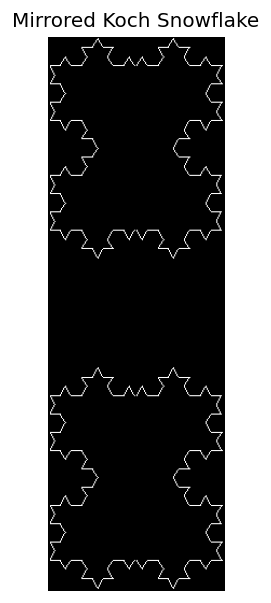

In [35]:
# Generate
segments = initialize_triangle_segments()
for _ in range(4):
    segments = koch_iteration_step(segments)

# Slice and mirror
sliced = slice_and_mirror_segments(segments, fraction=0.1)

# Rasterize
mask = rasterize_segments_to_image(sliced, image_size=512, padding_pixels=2)

# Show
plt.figure(figsize=(6,6))
plt.imshow(mask, cmap='gray')
plt.title("Mirrored Koch Snowflake")
plt.axis('off')
plt.show()

Max local thickness (including self): 5


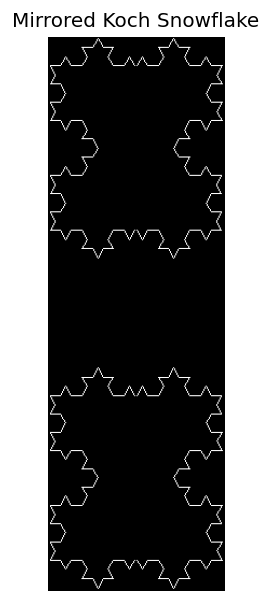

In [36]:
# Rasterize

mask = rasterize_segments_to_image_2(sliced, image_size=512, padding_pixels=2)
thickness = estimate_local_thickness(mask)
max_thickness = np.max(thickness)
print("Max local thickness (including self):", max_thickness)
mask_filled = binary_fill_holes(mask)

# Show
plt.figure(figsize=(6,6))
plt.imshow(mask_filled, cmap='gray')
plt.title("Mirrored Koch Snowflake")
plt.axis('off')
plt.show()

In [9]:
def check_edge_contact(mask):
    """
    Checks if the binary mask has any white pixels touching the image edges.
    
    Args:
        mask: 2D binary numpy array (bool or int)
        
    Returns:
        has_edge_contact (bool): True if any edge pixels are True
        edge_counts (dict): Number of True pixels on each edge
    """
    top = mask[0, :]
    bottom = mask[-1, :]
    left = mask[:, 0]
    right = mask[:, -1]

    edge_counts = {
        'top': int(np.sum(top)),
        'bottom': int(np.sum(bottom)),
        'left': int(np.sum(left)),
        'right': int(np.sum(right))
    }

    has_contact = any(count > 0 for count in edge_counts.values())
    return has_contact, edge_counts

check_edge_contact(mask)

(True, {'top': 14, 'bottom': 2, 'left': 120, 'right': 2})

In [43]:
# CONFIG
BASE_SCALE = 0.7
NUM_ITERATIONS = 8  # number of Koch refinement steps
MIN_SIZE = 1024
MAX_SIZE = 4096
NUM_SIZES =100
SAVE_PREFIX = "koch_run_parallel"
BATCH_SIZE = 5

# 1. Initialize Base Triangle
segments = initialize_triangle_segments(scale=BASE_SCALE)

# 2. Koch Iterations
for _ in range(NUM_ITERATIONS):
    segments = koch_iteration_step(segments)



Rasterizing and Measuring:   5%|▌         | 5/100 [00:43<1:09:04, 43.63s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_5.npz


Rasterizing and Measuring:  10%|█         | 10/100 [01:25<18:58, 12.64s/it] 

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_10.npz


Rasterizing and Measuring:  15%|█▌        | 15/100 [02:06<14:31, 10.25s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_15.npz


Rasterizing and Measuring:  20%|██        | 20/100 [02:47<12:22,  9.28s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_20.npz


Rasterizing and Measuring:  25%|██▌       | 25/100 [03:28<11:04,  8.86s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_25.npz


Rasterizing and Measuring:  30%|███       | 30/100 [04:09<10:04,  8.63s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_30.npz


Rasterizing and Measuring:  35%|███▌      | 35/100 [07:27<20:40, 19.09s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_35.npz


Rasterizing and Measuring:  40%|████      | 40/100 [08:10<15:40, 15.67s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_40.npz


Rasterizing and Measuring:  45%|████▌     | 45/100 [08:52<12:14, 13.36s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_45.npz


Rasterizing and Measuring:  50%|█████     | 50/100 [09:34<09:51, 11.83s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_50.npz


/Users/manas/Desktop/clouds_project/percolation/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Rasterizing and Measuring:  55%|█████▌    | 55/100 [24:30<47:34, 63.43s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_55.npz


Rasterizing and Measuring:  60%|██████    | 60/100 [25:14<31:08, 46.70s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_60.npz


Rasterizing and Measuring:  65%|██████▌   | 65/100 [25:56<20:27, 35.08s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_65.npz


Rasterizing and Measuring:  70%|███████   | 70/100 [26:39<13:30, 27.02s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_70.npz


Rasterizing and Measuring:  75%|███████▌  | 75/100 [29:10<11:40, 28.03s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_75.npz


Rasterizing and Measuring:  80%|████████  | 80/100 [29:53<07:23, 22.17s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_80.npz


Rasterizing and Measuring:  85%|████████▌ | 85/100 [30:35<04:30, 18.03s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_85.npz


Rasterizing and Measuring:  90%|█████████ | 90/100 [31:18<02:31, 15.17s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_90.npz


Rasterizing and Measuring:  95%|█████████▌| 95/100 [32:00<01:05, 13.16s/it]

Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_95.npz


Rasterizing and Measuring: 100%|██████████| 100/100 [32:43<00:00, 19.64s/it]


Saved intermediate data at intermediate_saves/koch_run_parallel_up_to_100.npz


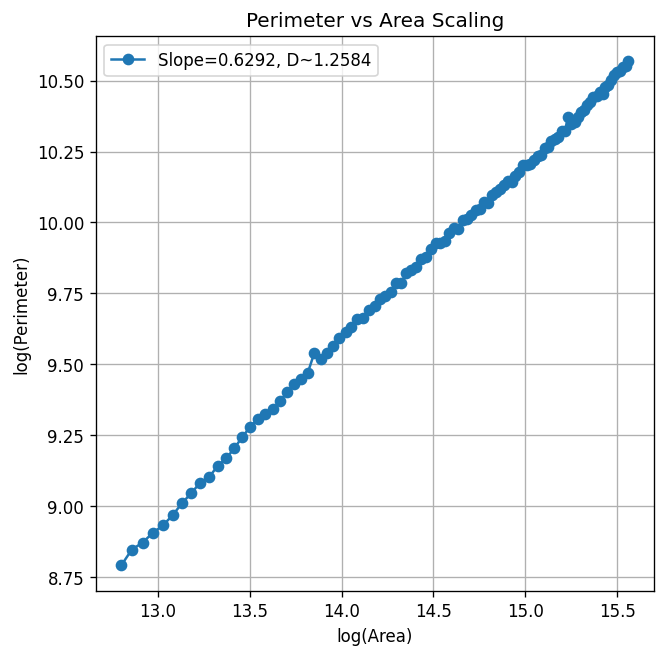

Estimated Fractal Dimension D ≈ 1.2584


Rasterizing and Measuring:   0%|          | 0/100 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# 3. Rasterize and Measure
areas, perimeters, sizes = multi_raster_area_perimeter_parallel_safe(
    segments,
    min_size=MIN_SIZE,
    max_size=MAX_SIZE,
    num_sizes=NUM_SIZES,
    plot_some=False,
    save_every=10,
    save_prefix=SAVE_PREFIX,
    batch_size=BATCH_SIZE,
    n_jobs=-1
)

# 4. Estimate D
D_estimate = plot_loglog_perimeter_vs_area(areas, perimeters)
print(f"Estimated Fractal Dimension D ≈ {D_estimate:.4f}")

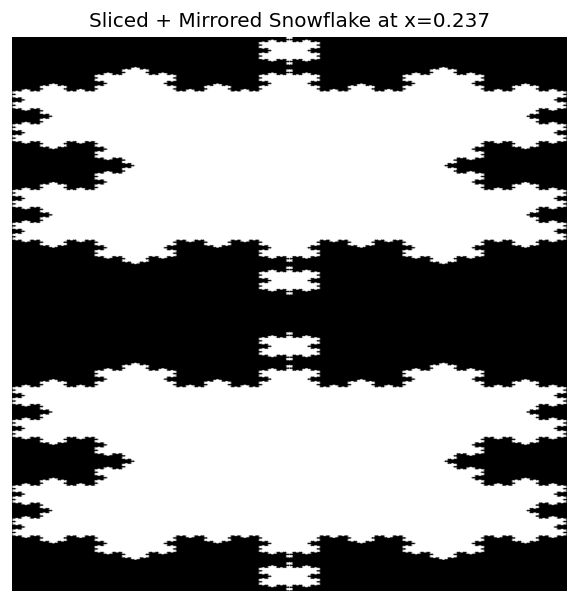

In [ ]:
sliced_and_mirrored_segments, x_cut = slice_and_mirror_segments(segments, fraction=1/8)

# 2. Rasterize at larger canvas (say, still 4096 for now)
# (the mirrored version is within [0, 2*x_cut range], so should fit into the canvas)
sliced_mirrored_mask = rasterize_segments_to_image(sliced_and_mirrored_segments, image_size=4096)

# 3. Show
plt.figure(figsize=(6,6))
plt.imshow(sliced_mirrored_mask, cmap='gray')
plt.title(f"Sliced + Mirrored Snowflake at x={x_cut:.3f}")
plt.axis('off')
plt.show()

Processing slices:   0%|          | 0/3 [00:00<?, ?it/s]


=== Starting slice at fraction 0.10 ===


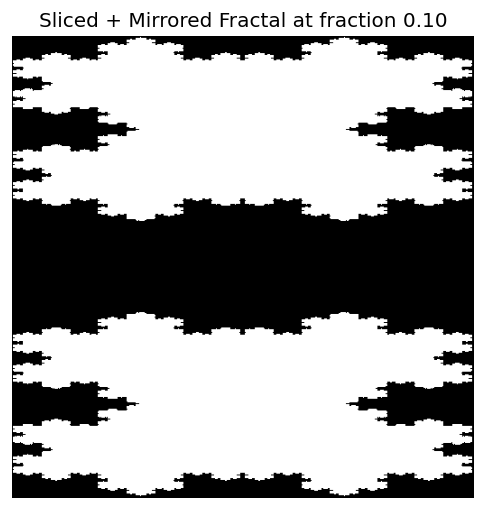

                                                        
Processing slices:   0%|          | 0/3 [00:17<?, ?it/s]                

Saved intermediate data at intermediate_saves/slice_frac_0.10_up_to_2.npz


Rasterizing and Measuring: 100%|██████████| 2/2 [00:11<00:00,  5.97s/it]


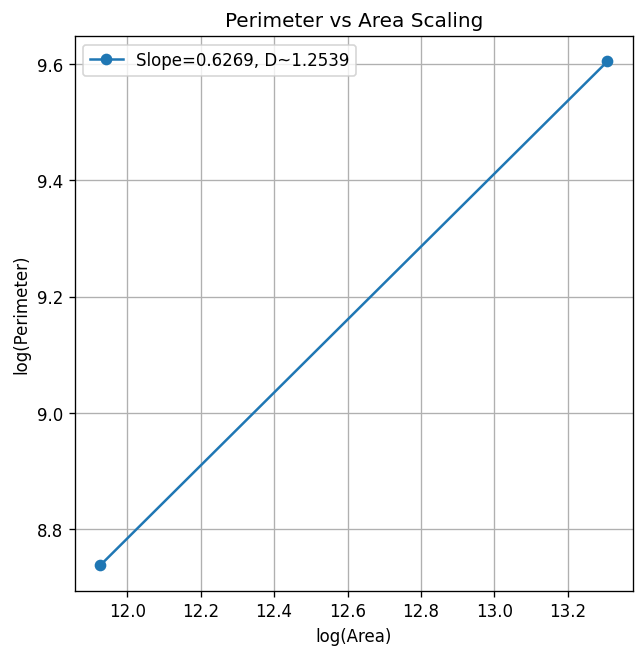


=== Starting slice at fraction 0.20 ===


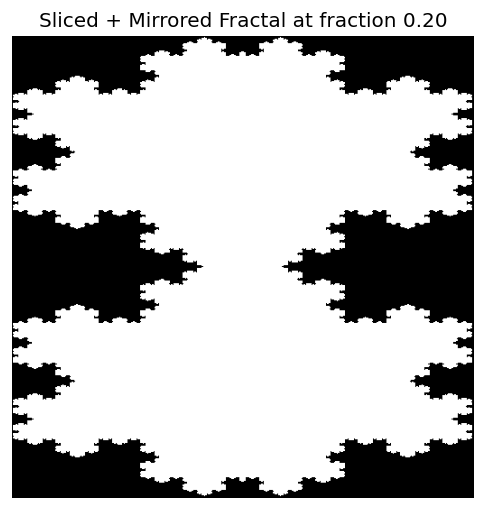


Rasterizing and Measuring: 100%|██████████| 2/2 [00:15<00:00,  7.62s/it]


Saved intermediate data at intermediate_saves/slice_frac_0.20_up_to_2.npz


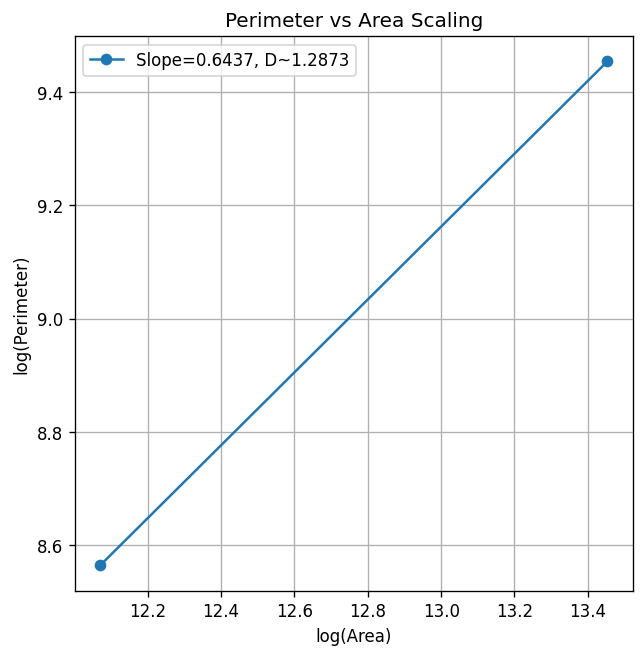


=== Starting slice at fraction 0.30 ===


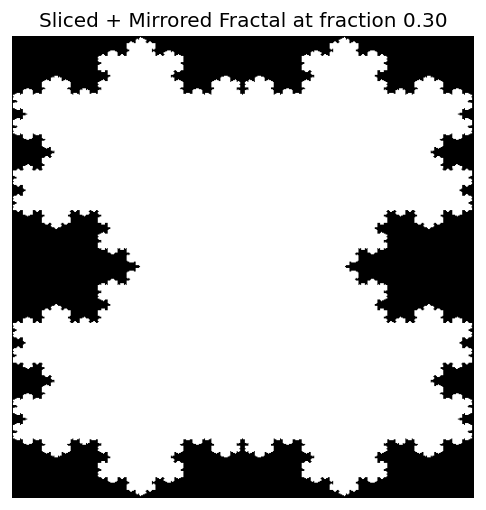

                                                        
Rasterizing and Measuring: 100%|██████████| 2/2 [00:17<00:00,  8.83s/it]


Saved intermediate data at intermediate_saves/slice_frac_0.30_up_to_2.npz


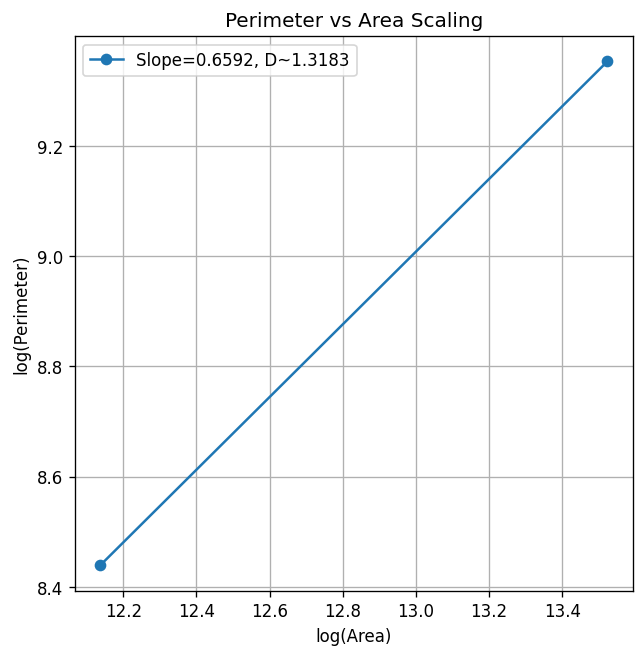

Processing slices:   0%|          | 0/3 [01:11<?, ?it/s]


In [ ]:
import pandas as pd
import time
from tqdm import tqdm

# Parameters (small for fast test run)
BASE_SCALE = 0.4
NUM_ITERATIONS = 8      # small, fast
MIN_SIZE = 512
MAX_SIZE = 1024         # low max size
NUM_SIZES = 2           # very few raster sizes
BATCH_SIZE = 2
MARGIN_PIXELS = 2

# Prepare for the slicing run
fractions = np.linspace(0.1, 0.3, 3)  # just 3 fractions to test
results = []  # to store final D estimates

# Start from base triangle
segments = initialize_triangle_segments(scale=BASE_SCALE)

# Koch iterations
for _ in range(NUM_ITERATIONS):
    segments = koch_iteration_step(segments)

start_time = time.time()

# Progress bar over all slice fractions
with tqdm(total=len(fractions), desc="Processing slices") as pbar:
    for frac in fractions:
        print(f"\n=== Starting slice at fraction {frac:.2f} ===")

        # 1. Slice and mirror
        sliced_mirrored_segments = slice_and_mirror_segments(segments, fraction=frac)

        # 2. Rasterize just to visualize the mirrored snowflake
        preview_mask = rasterize_segments_to_image(sliced_mirrored_segments, image_size=512)
        plt.figure(figsize=(5,5))
        plt.imshow(preview_mask, cmap='gray')
        plt.title(f"Sliced + Mirrored Fractal at fraction {frac:.2f}")
        plt.axis('off')
        plt.show()

        # 3. Multi raster
        areas, perimeters, sizes = multi_raster_area_perimeter_parallel_safe(
            sliced_mirrored_segments,
            min_size=MIN_SIZE,
            max_size=MAX_SIZE,
            num_sizes=NUM_SIZES,
            plot_some=False,
            save_every=2,
            save_prefix=f"slice_frac_{frac:.2f}",
            batch_size=BATCH_SIZE,
            n_jobs=-1
        )

        # 4. Fit D
        try:
            D_estimate = plot_loglog_perimeter_vs_area(areas, perimeters)
        except Exception as e:
            print(f"Error fitting D for fraction {frac:.2f}: {e}")
            D_estimate = np.nan

        # 5. Save to results
